# Translating Hyperbolic Function: Generating Training and Test Data

In [13]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE    
from PCAfold         import PCA          as PCAA

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


## Defining Input Variables

In [2]:
OutputDir       = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/TransTanh_100Cases/')
FigDir          = os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')


n_training  = 100
n_test      = 10  
Nt          = 500
tout        = np.linspace(0.,15.,Nt)
SOLVER      = 'BDF'

MinVals     = [5.]
MaxVals     = [10.]
aParam      = 1.
bParam      = 1.


ColorVec    = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

OutputDir += '/Orig/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

TempDir = OutputDir+'/train/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = TempDir+'/ext/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = OutputDir+'/test/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = TempDir+'/ext/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

## ODE

In [3]:
def fOrig(t, y):
    return [Params[1]/(np.cosh(Params[0]*Params[2]-t)**2)]

## Sampling and Plotting Initial Conditions

In [4]:
### From Uniform Distibutions

# y0Mat      = np.zeros((n_training,2))
# y0Mat[:,0] = np.random.rand(n_training)*4. - 2.0
# y0Mat[:,1] = np.random.rand(n_training)*4. - 2.0

# y0MatTest      = np.zeros((n_test,2))
# y0MatTest[:,0] = np.random.rand(n_test)*4. - 2.0
# y0MatTest[:,1] = np.random.rand(n_test)*2. - 1.0


### From Latin Hypercube 

y0Mat     = pyDOE.lhs(1, samples=n_training, criterion='center')
for i in range(1):
    y0Mat[:,i] = y0Mat[:,i] * (MaxVals[i] - MinVals[i]) + MinVals[i]

y0MatTest     = pyDOE.lhs(1, samples=n_test, criterion='center')
for i in range(1):
    y0MatTest[:,i] = y0MatTest[:,i] * (MaxVals[i] - MinVals[i]) + MinVals[i]

## Generating Training Data

/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
<ipython-input-3-0ee14b7a395b>:2: RuntimeWarning: overflow encountered in cosh
  return [Params[1]/(np.cosh(Params[0]*Params[2]-t)**2)]
/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
<ipython-input-3-0ee14b7a395b>:2: RuntimeWarning: overflow encountered in cosh
  return [Params[1]/(np.cosh(Params[0]*Params[2]-t)**2)]
/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
<ipython-input-3-0ee14b7a395b>:2: RuntimeWarning: overflow encountered in double_scalars
  return [Params[1]/(np.cosh(Params[0]*

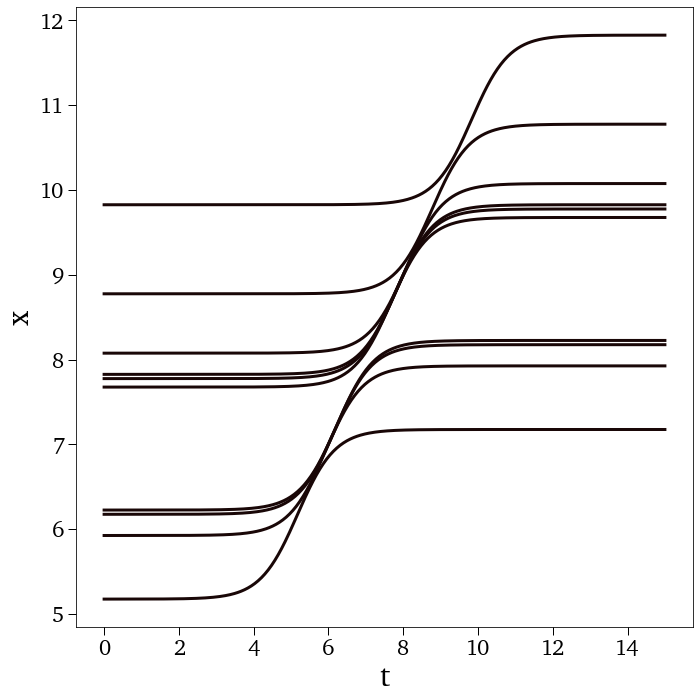

In [14]:
Params = np.zeros(3)

fig = plt.figure()
for iSample in range(n_training):
    y0         = y0Mat[iSample,:]
    #print('y0 = ', y0)
    Params[0]  = y0Mat[iSample,0]
    Params[1]  = aParam
    Params[2]  = bParam
    
    output     = solve_ivp( fOrig, tout[[0,-1]], y0, method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-20 )
    
    tMatTemp   = tout[...,np.newaxis]
    uMatTemp   = np.tile(y0, (Nt, 1))
    
    if (iSample//10 == 0):
        plt.plot(output.t, output.y[0,:], color=ColorVec[0])
        #plt.plot(output.t, Params[1]*( np.tanh(output.t-Params[0]*Params[2]) + np.tanh(Params[0]*Params[2])) + Params[0], color='r')

    if (iSample == 0):
        tMat    = tMatTemp
        uMat    = uMatTemp
        yMat    = output.y.T 
        zMat    = output.y.T 
    else:
        tMat    = np.concatenate((tMat,    tMatTemp), axis=0)
        uMat    = np.concatenate((uMat,    uMatTemp), axis=0)
        yMat    = np.concatenate((yMat,    output.y.T), axis=0)
        zMat    = np.concatenate((zMat,    output.y.T), axis=1)

    Header   = 't,x'
    FileName = OutputDir+'/train/ext/y.csv.'+str(iSample+1)
    np.savetxt(FileName, np.concatenate((tMatTemp,output.y.T), axis=1), delimiter=',', header=Header, comments='')
        
        
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.tick_params(axis='y')
#ax1.set_ylim([-6.,6.])

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if (FigDir):
    plt.savefig(FigDir+'/TransTanh_TrainDynamics.eps', format='eps', bbox_inches='tight')

## Splitting and Writing Training Data

In [6]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/valid/')
except:
    pass

In [7]:
data_id    = 'pts'

DataInput  = pd.DataFrame(np.concatenate((tMat,uMat), axis=1), columns=['t','x'])
DataOutput = pd.DataFrame(np.concatenate((tMat,yMat), axis=1), columns=['t','x'])
                          
n_points   = len(DataInput)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=0.2, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/valid/'+data_id+'/')
except:
    pass

DataInput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Input.csv', index=False)

DataOutput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Output.csv', index=False)

In [8]:
data_id    = 'ics'

t0Mat      = np.zeros((y0Mat.shape[0],1))
u0Mat      = y0Mat

DataInput  = pd.DataFrame(np.concatenate((t0Mat,u0Mat), axis=1), columns=['t','x'])
DataOutput = pd.DataFrame(np.concatenate((t0Mat,u0Mat), axis=1), columns=['t','x'])
                          
n_points   = len(DataInput)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=0.2, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/valid/'+data_id+'/')
except:
    pass

DataInput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Input.csv', index=False)

DataOutput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Output.csv', index=False)

In [9]:
data_id    = 'res'

DataInput  = pd.DataFrame(np.concatenate((tMat,uMat), axis=1), columns=['t','x'])
DataOutput = pd.DataFrame(np.concatenate((tMat,yMat*0.), axis=1), columns=['t','x'])
                          
n_points   = len(DataInput)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=0.2, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/valid/'+data_id+'/')
except:
    pass

DataInput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Input.csv', index=False)

DataOutput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Output.csv', index=False)

## Generating Test Data

/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
<ipython-input-3-0ee14b7a395b>:2: RuntimeWarning: overflow encountered in cosh
  return [Params[1]/(np.cosh(Params[0]*Params[2]-t)**2)]
/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
<ipython-input-3-0ee14b7a395b>:2: RuntimeWarning: overflow encountered in cosh
  return [Params[1]/(np.cosh(Params[0]*Params[2]-t)**2)]
/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
<ipython-input-3-0ee14b7a395b>:2: RuntimeWarning: overflow encountered in cosh
  return [Params[1]/(np.cosh(Params[0]*Params[2]-

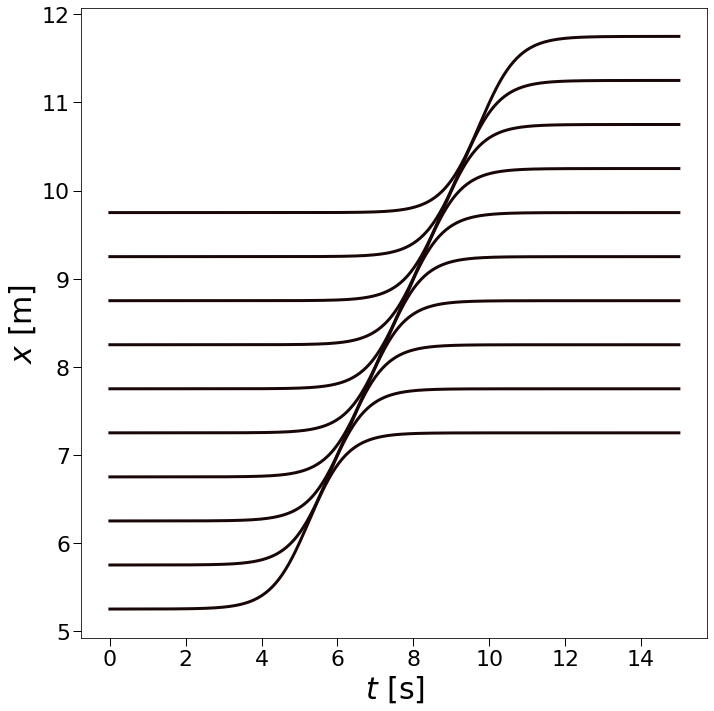

In [10]:
Params = np.zeros(3)

fig = plt.figure()
for iSample in range(n_test):
    y0         = y0MatTest[iSample,:]
    #print('y0 = ', y0)
    Params[0]  = y0MatTest[iSample,0]
    Params[1]  = aParam
    Params[2]  = bParam
    
    
    output     = solve_ivp( fOrig, tout[[0,-1]], y0, method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-20 )
    
    tMatTemp   = tout[...,np.newaxis]
    uMatTemp   = np.tile(y0, (Nt, 1))
    
    plt.plot(output.t, output.y[0,:], color=ColorVec[0])

    if (iSample == 0):
        tMatTest    = tMatTemp
        uMatTest    = uMatTemp
        yMatTest    = output.y.T 
    else:
        tMatTest    = np.concatenate((tMatTest,    tMatTemp), axis=0)
        uMatTest    = np.concatenate((uMatTest,    uMatTemp), axis=0)
        yMatTest    = np.concatenate((yMatTest,    output.y.T), axis=0)
        
    Header   = 't,x'
    FileName = OutputDir+'/test/ext/y.csv.'+str(iSample+1)
    np.savetxt(FileName, np.concatenate((tMatTemp,output.y.T), axis=1), delimiter=',', header=Header, comments='')
        
        
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.tick_params(axis='y')
#ax1.set_ylim([-6.,6.])

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if (FigDir):
    plt.savefig(FigDir+'/TransTanh_TestDynamics.eps', format='eps', bbox_inches='tight')

In [11]:
## Writing Test Data

In [12]:
TestDir  = OutputDir+'/test/ext/'

Header   = 't,x'
FileName = TestDir+'/Input.csv'
np.savetxt(FileName, np.concatenate((tMatTest,uMatTest), axis=1), delimiter=',', header=Header, comments='')
        
Header   = 't,x'
FileName = TestDir+'/Output.csv'
np.savetxt(FileName, np.concatenate((tMatTest,yMatTest), axis=1), delimiter=',', header=Header, comments='')